In [1]:
## DATA OVERVIEW

import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline

# Load dataset
df = pd.read_csv('/content/bank_data.csv')
df.head()


,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


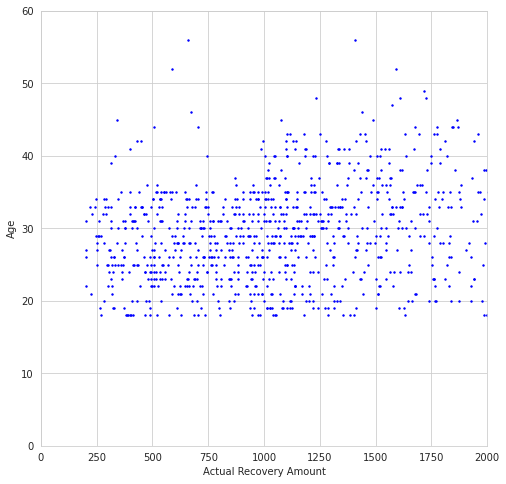

Kruksal Values for Age around the Discountinuity:  KruskalResult(statistic=2.8377050571294737, pvalue=0.09207563391978797) 



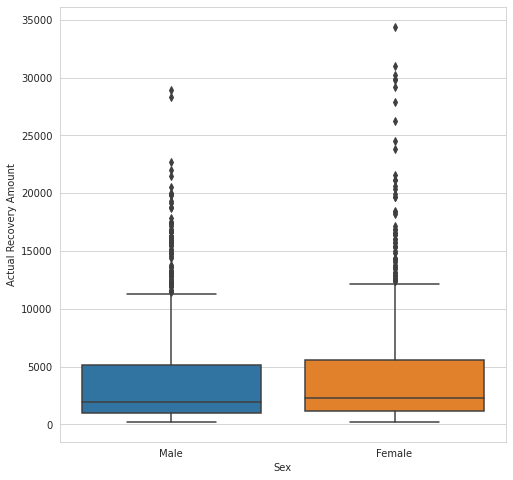

Chi-Square Stat and p-value: 1.2564211799045006 0.5335456793121544 



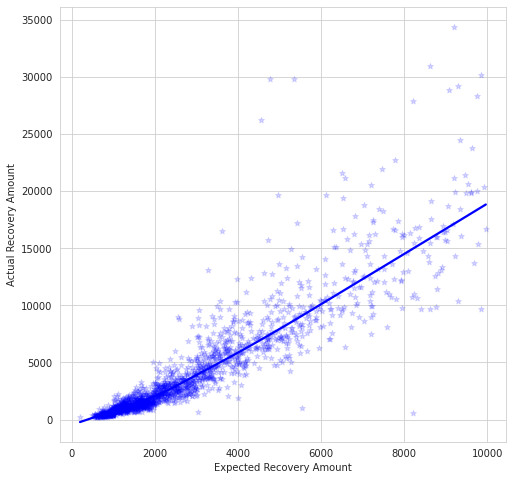

Kruksal Values for Recovery Strategy 0-1 around the bigger Discountinuity:  KruskalResult(statistic=0.8626939682811212, pvalue=0.3529859002714304)
Kruksal Values for Recovery Strategy 0-1 around the smaller Discountinuity:  KruskalResult(statistic=0.03841128821528628, pvalue=0.844619574300571) 



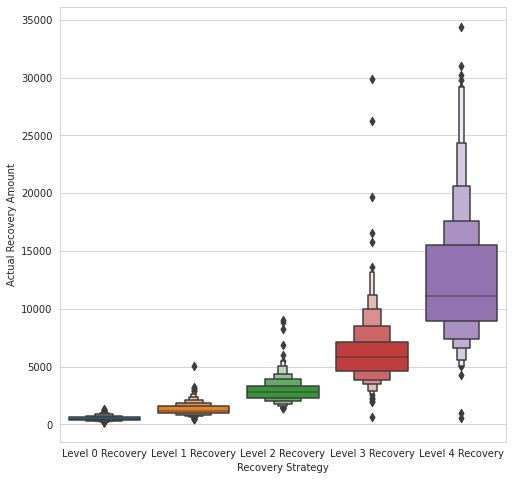

Chi-Square Stat and p-value: 314.0 1.0337688178101369e-66


In [2]:
## EDA VISUALIZATIONS

import warnings
warnings.filterwarnings("ignore")

# Age vs. Actual Recovery Amount

# Scatter plot of Age vs. Actual Recovery Amount
plt.figure(figsize=(8,8))
plt.scatter(x=df['actual_recovery_amount'], y=df['age'], c="b", s=2)
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel('Actual Recovery Amount')
plt.ylabel('Age')
plt.show()
# Compute average age just below and above the threshold
era_900_1100 = df.loc[(df['actual_recovery_amount']<1100) & (df['actual_recovery_amount']>=900)]
by_recovery_strategy = era_900_1100.groupby(['recovery_strategy'])
by_recovery_strategy['age'].describe().unstack()
# Kruskal-Wallis test 
Level_0_age = era_900_1100.loc[df['recovery_strategy']=="Level 0 Recovery"]['age']
Level_1_age = era_900_1100.loc[df['recovery_strategy']=="Level 1 Recovery"]['age']
print('Kruksal Values for Age around the Discountinuity: ', stats.kruskal(Level_0_age, Level_1_age), '\n')

# Sex vs. Actual Recovery Amount

# Preparing data
crosstab = pd.crosstab(df.loc[(df['actual_recovery_amount']<1100) & (df['actual_recovery_amount']>=900)]['recovery_strategy'], df['sex'])
# Box plot of Sex vs. Expected Recovery Amount 
plt.figure(figsize=(8,8))
sns.boxplot(y=df['actual_recovery_amount'], x=df['sex'], )
plt.ylabel("Actual Recovery Amount")
plt.xlabel("Sex")
plt.show()
# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print('Chi-Square Stat and p-value: {} {}'.format(chi2_stat, p_val), '\n')

# Expected Recovery Amount vs. Actual Recovery Amount

# Scatter plot of Actual Recovery Amount vs. Expected Recovery Amount
plt.figure(figsize=(8,8)) 
sns.regplot(x=df['expected_recovery_amount'], y=df['actual_recovery_amount'], color="blue", x_jitter=True, y_jitter=True, lowess=True, marker='*', scatter_kws={'alpha':0.15})
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual Recovery Amount")
plt.show()
# Compute average actual recovery amount just below and above the threshold
by_recovery_strategy['actual_recovery_amount'].describe().unstack()
# Perform Kruskal-Wallis test
Level_0_actual = era_900_1100.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_900_1100.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
print('Kruksal Values for Recovery Strategy 0-1 around the bigger Discountinuity: ', stats.kruskal(Level_0_actual, Level_1_actual))
# Repeat for a smaller range of $950 to $1050
era_950_1050 = df.loc[(df['actual_recovery_amount']<1050) & (df['actual_recovery_amount']>=950)]
Level_0_actual2 = era_950_1050.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual2 = era_950_1050.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
print('Kruksal Values for Recovery Strategy 0-1 around the smaller Discountinuity: ', stats.kruskal(Level_0_actual2, Level_1_actual2), '\n')

# Reovery Strategy vs. Actual Recovery Amount

# Preparing data
crosstab2 = pd.crosstab(df.loc[(df['actual_recovery_amount']<1100) & (df['actual_recovery_amount']>=900)]['recovery_strategy'], df['recovery_strategy'])
# Box plot of different Strategies vs. Expected recovery Amount
plt.figure(figsize=(8,8))
sns.boxenplot(y=df['actual_recovery_amount'], x=df['recovery_strategy'], )
plt.ylabel("Actual Recovery Amount")
plt.xlabel("Recovery Strategy")
plt.show()
# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab2)
print('Chi-Square Stat and p-value: {} {}'.format(chi2_stat, p_val))



                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.007
Model:                                OLS   Adj. R-squared:                  0.001
Method:                     Least Squares   F-statistic:                     1.163
Date:                    Thu, 24 Nov 2022   Prob (F-statistic):              0.282
Time:                            17:49:57   Log-Likelihood:                -851.77
No. Observations:                     157   AIC:                             1708.
Df Residuals:                         155   BIC:                             1714.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

Text(0.5, 1.0, 'Effect of Recovery Strategy 1')

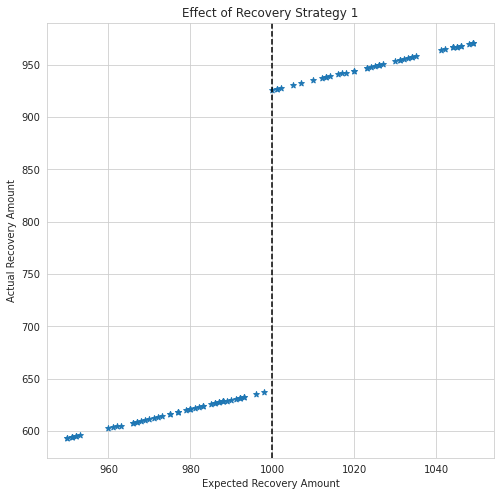

In [3]:
## MODEL

# Regression without threshold
X = era_900_1100['expected_recovery_amount']
y = era_900_1100['actual_recovery_amount']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary(), '\n')

# Regression with threshold = indicator variable
df['indicator_1000'] = np.where(df['expected_recovery_amount']<1000, 0, 1)
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) & (df['expected_recovery_amount']>=900)]
X2 = era_900_1100[['expected_recovery_amount', 'indicator_1000', ]]
y2 = era_900_1100['actual_recovery_amount']
X2 = sm.add_constant(X2)
model2 = sm.OLS(y2,X2).fit()
predictions2 = model2.predict(X2)
print(model2.summary(), '\n')

# Regression with smaller threshold interval
era_950_1050 = df.loc[(df['expected_recovery_amount']<1050) & (df['expected_recovery_amount']>=950)]
X3 = era_950_1050[['expected_recovery_amount','indicator_1000']]
y3 = era_950_1050['actual_recovery_amount']
X3 = sm.add_constant(X3)
model3 = sm.OLS(y3,X3).fit()
predictions3 = model3.predict(X3)
print(model3.summary(), '\n')

plt.figure(figsize=(8,8))
plt.scatter(X3['expected_recovery_amount'], predictions3, marker='*')
plt.axvline(1000, color='black', linestyle='--')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.title('Effect of Recovery Strategy 1')


Text(0.5, 1.0, 'Effect of Recovery Strategy 2')

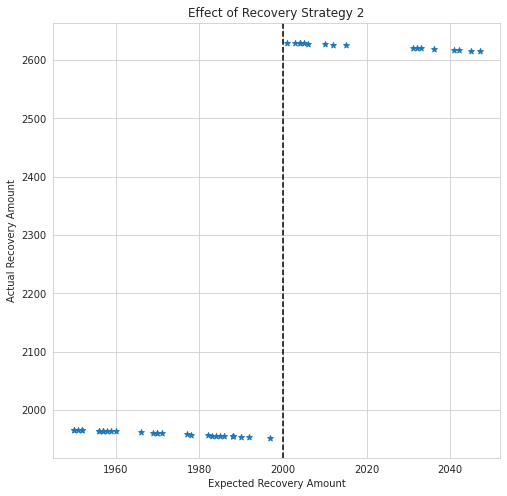

In [4]:
## MODEL EVALUATION 1

# RDD for the second level
df['indicator_2000'] = np.where(df['expected_recovery_amount']<2000, 0, 1)
era_1950_2050 = df.loc[(df['expected_recovery_amount']<2050) & (df['expected_recovery_amount']>=1950)]
X4 = era_1950_2050[['expected_recovery_amount','indicator_2000']]
y4 = era_1950_2050['actual_recovery_amount']
X4 = sm.add_constant(X4)
model4 = sm.OLS(y4,X4).fit()
predictions4 = model4.predict(X4)

plt.figure(figsize=(8,8))
plt.scatter(X4['expected_recovery_amount'], predictions4, marker='*')
plt.axvline(2000, color='black', linestyle='--')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.title('Effect of Recovery Strategy 2')

Text(0.5, 1.0, 'Effect of Recovery Strategy 3')

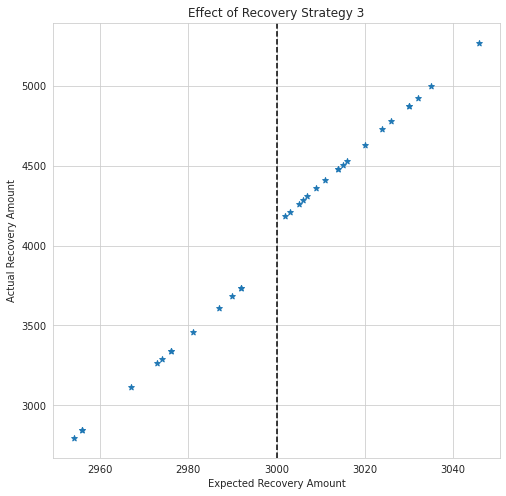

In [5]:
## MODEL EVALUATION 2

# RDD for the third level
df['indicator_3000'] = np.where(df['expected_recovery_amount']<3000, 0, 1)
era_2950_3050 = df.loc[(df['expected_recovery_amount']<3050) & (df['expected_recovery_amount']>=2950)]
X5 = era_2950_3050[['expected_recovery_amount','indicator_3000']]
y5 = era_2950_3050['actual_recovery_amount']
X5 = sm.add_constant(X5)
model5 = sm.OLS(y5,X5).fit()
predictions5 = model5.predict(X5)

plt.figure(figsize=(8,8))
plt.scatter(X5['expected_recovery_amount'], predictions5, marker='*')
plt.axvline(3000, color='black', linestyle='--')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.title('Effect of Recovery Strategy 3')


Text(0.5, 1.0, 'Effect of Recovery Strategy 4')

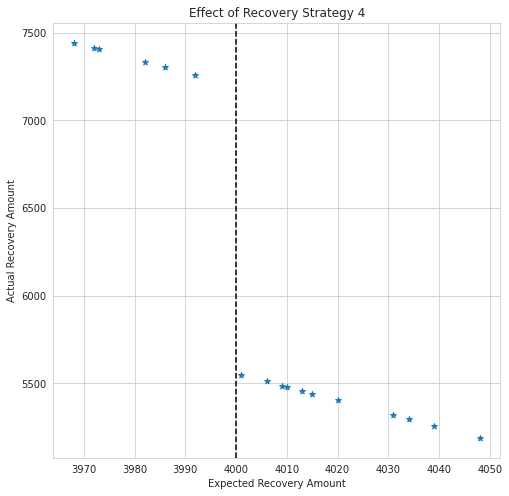

In [6]:
## MODEL EVALUATION 3

# RDD for the fourth level
df['indicator_4000'] = np.where(df['expected_recovery_amount']<4000, 0, 1)
era_3950_4050 = df.loc[(df['expected_recovery_amount']<4050) & (df['expected_recovery_amount']>=3950)]
X6 = era_3950_4050[['expected_recovery_amount','indicator_4000']]
y6 = era_3950_4050['actual_recovery_amount']
X6 = sm.add_constant(X6)
model6 = sm.OLS(y6,X6).fit()
predictions6 = model6.predict(X6)

plt.figure(figsize=(8,8))
plt.scatter(X6['expected_recovery_amount'], predictions6, marker='*')
plt.axvline(4000, color='black', linestyle='--')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.title('Effect of Recovery Strategy 4')
